# Generate Standard 205 YAML for Unitary Air-Conditioning

In [1]:
import yaml
import uuid
import csv
from datetime import datetime

In [2]:
import re
from cStringIO import StringIO

def _fix_dump(dump, indentSize=2):
    stream = StringIO(dump)
    out = StringIO()
    pat = re.compile('(\s*)([^:]*)(:*)')
    last = None

    prefix = 0
    for s in stream:    
        indent, key, colon = pat.match(s).groups()
        if indent=="" and key[0]!= '-':
            prefix = 0 
        if last:
            if len(last[0])==len(indent) and last[2]==':':
                if all([
                        not last[1].startswith('-'), 
                        s.strip().startswith('-')
                        ]):
                    prefix += indentSize
            elif len(last[0])==len(indent):
                if all([
                        last[1].startswith('-'), 
                        not s.strip().startswith('-')
                        ]):
                    prefix -= indentSize
        out.write(" "*prefix+s)
        last = indent, key, colon
    return out.getvalue()

In [3]:
example = {}  # Top level dictionary

## ASHRAE 205 Header

In [4]:
a205 = {}
a205["RSID"] = "0002"
a205["RSTitle"] = "Unitary Cooling Air-Conditioning Equipment"
a205["RSVersion"] = 1
a205["ID"] = str(uuid.uuid4())
a205["description"] = "Example Unitary Air-Conditioner"
a205["dataDate"] = '{}'.format(datetime.now().date())
a205["dataSource"] = "Synthetic (Generated by N. Kruis)"
a205["dataVersion"] = '1'
a205["notes"] = "This dataset is purley for illustrative purposes. Use at your own risk."

example["ASHRAE205"] = a205

## General Data

In [5]:
gd = {}
gd["compressorControlMethod"] = "Staged"
gd["blowerID"] = "399b1308-09e6-4891-8cd7-ea40c86f7e40"
gd["blowerPosition"] = "Draw Through"
gd["nominalVolumetricAirFlowRate"] = 0.646
gd["cyclingDegradationCoefficient"] = 0.25
gd["refrigerantType"] = "R-140a"
gd["compressorType"] = "Scroll"
gd["expansionDeviceType"] = "TXV"

example["GeneralData"] = gd

## AHRI Residential Ratings

In [6]:
arr = {}
arr["certifiedReferenceNumber"] = 1234567
arr["testStandardVersion"] = "AHRI 210/240 2008"
arr["manufacturerSoftwareVersion"] = "2.1"
arr["outdoorUnitManufacturer"] = "Manufacturer"
arr["outdoorUnitModelNumber"] = "OU-1"
arr["indoorUnitManufacturer"] = "Manufacturer"
arr["indoorUnitModelNumber"] = "IU-1"
arr["seer"] = 13.0
arr["eer"] = 11.0
arr["capacity"] = 5.16e3
arr["blowerEfficiency"] = 226.

example["AHRIResidentialRatings"] = arr

## Performance Map (Cooling)

In [7]:
pmc = {}
ppc = {}
todb = []
tedb = []
tewb = []
v = []
p = []
c = []
qt = []
pd = []
qs = []

with open('map.csv','r') as mapfile:
    csvreader = csv.reader(mapfile)
    for row in csvreader:
        todb.append(float(row[0]))
        tewb.append(float(row[1]))
        tedb.append(float(row[2]))
        v.append(float(row[3]))
        c.append(1.0)
        p.append(float(row[4]))
        qt.append(float(row[5]))
        pd.append(float(row[6]))
        qs.append(float(row[7]))

ppc["outdoorCoilEnteringDryBulbTemperature"] = todb
ppc["indoorCoilEnteringWetBulbTemperature"] = tewb
ppc["indoorCoilEnteringDryBulbTemperature"] = tedb
ppc["indoorCoilVolumetricFlowRatio"] = v
ppc["compressorSpeedRatio"] = c
ppc["ambientAbsoluteAirPressure"] = p
ppc["grossTotalCoolingCapacity"] = qt
ppc["grossSensibleCoolingCapacity"] = qs
ppc["grossCoolingPower"] = pd

pmc["PerformancePointsCooling"] = ppc

example["PerformanceMapCooling"] = pmc

## Performance Map Standby

In [8]:
pms = {}
pps = {}
pps["outdoorCoilEnvironmentDryBulbTemperature"] = [0.0, 5.0]
pps["grossPower"] = [50.0, 0.0]
pms["PerformancePointsStandby"] = pps

example["PerformanceMapStandby"] = pms

In [9]:
with open('unitary.yaml', 'w') as outfile:
    outfile.write( _fix_dump(yaml.dump(example, default_flow_style=False)) )

## Plotting

In [29]:
%matplotlib inline
import pandas as pd
import numpy as np
#import seaborn as sns
from scipy import interpolate

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import axes3d
plt.rcParams['figure.figsize'] = (10.0, 7.0)

In [170]:
df = pd.DataFrame(ppc)#[["grossCoolingPower","indoorCoilEnteringWetBulbTemperature","outdoorCoilEnteringDryBulbTemperature"]]

df = df[(df['ambientAbsoluteAirPressure'] == 100000.0) & (df['indoorCoilEnteringDryBulbTemperature'] == 23.9) & (df['indoorCoilVolumetricFlowRatio'] == 1.0)]

df = df[["outdoorCoilEnteringDryBulbTemperature","indoorCoilEnteringWetBulbTemperature","grossCoolingPower"]]



df

,outdoorCoilEnteringDryBulbTemperature,indoorCoilEnteringWetBulbTemperature,grossCoolingPower
14,12.8,13.9,969.0
41,12.8,19.4,1060.0
59,12.8,22.2,1020.0
86,35.0,13.9,1460.0
113,35.0,19.4,1480.0
131,35.0,22.2,1450.0
158,51.7,13.9,2170.0
185,51.7,19.4,2130.0
203,51.7,22.2,2180.0


In [141]:
def plot_map(xs,ys,zs,title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(xs,ys,zs,rstride=1,cstride=1, alpha = 0.5)
    ax.plot_surface(xorig,yorig,f(odbs,ewbs),rstride=1,cstride=1)
    ax.set_xlabel('ODB (C)')
    ax.set_ylabel('EWB (C)')
    ax.set_zlabel('Power (W)')
    ax.set_zlim(0,3500)
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)

    ax.set_title(title)

    ax.view_init(30, 220)
    ax.dist = 11
    plt.draw()

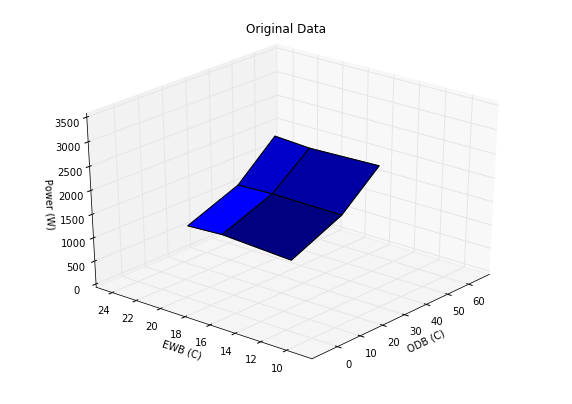

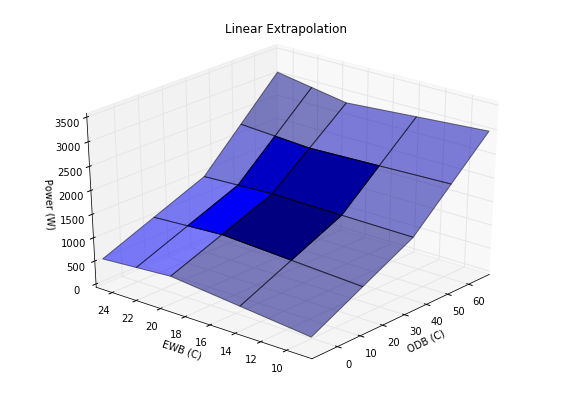

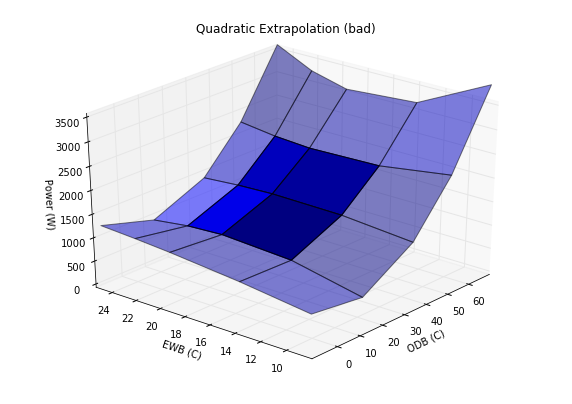

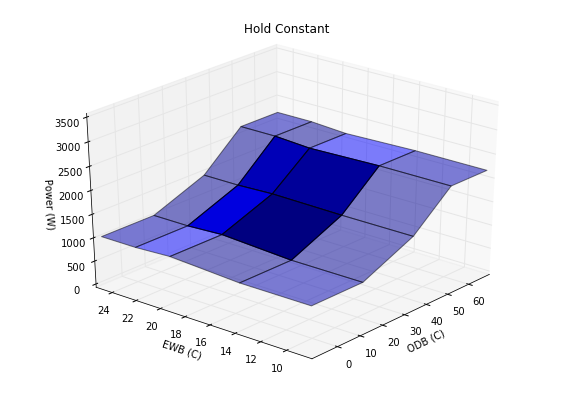

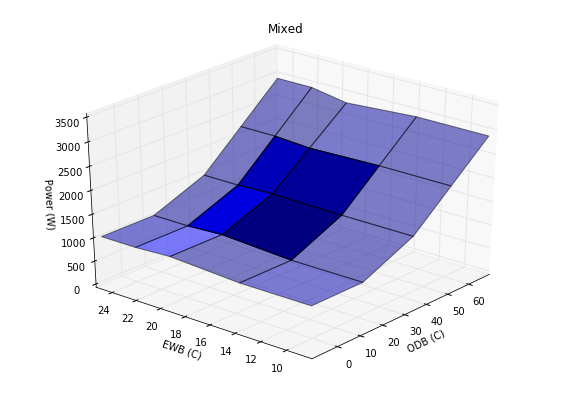

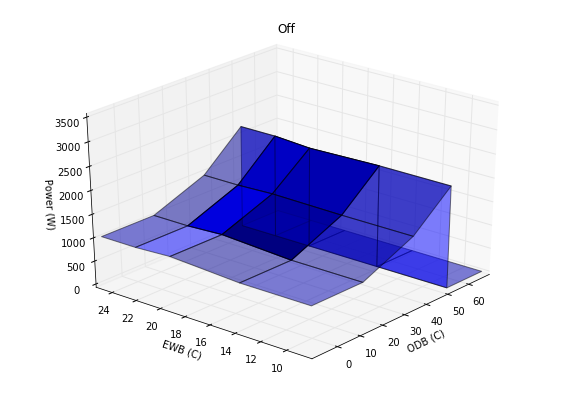

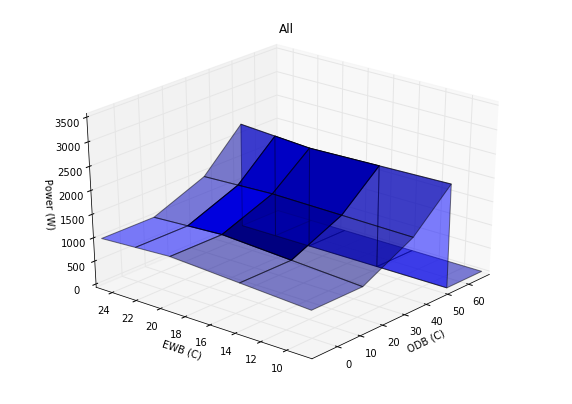

In [166]:
odb = df["outdoorCoilEnteringDryBulbTemperature"]
ewb = df["indoorCoilEnteringWetBulbTemperature"]
pwr = df["grossCoolingPower"]

odbs = sorted(odb.unique())
ewbs = sorted(ewb.unique())

xmin = odbs[0] - (odbs[1] - odbs[0])
xmax = odbs[-1] + (odbs[-1] - odbs[-2])
xnew = [xmin] + odbs + [xmax]

ymin = ewbs[0] - (ewbs[1] - ewbs[0])
ymax = ewbs[-1] + (ewbs[-1] - ewbs[-2])
ynew = [ymin] + ewbs + [ymax]

xarr = [[x]*len(ynew) for x in xnew]
yarr = [ynew]*len(xnew)

xorig = np.array([np.array(odb[0:3]),np.array(odb[3:6]),np.array(odb[6:9])])
yorig = np.array([np.array(ewb[0:3]),np.array(ewb[3:6]),np.array(ewb[6:9])])
z = np.array([np.array(pwr[0:3]),np.array(pwr[3:6]),np.array(pwr[6:9])])

f = interpolate.RectBivariateSpline(odbs,ewbs,z,kx=1,ky=1,bbox=[xmin,xmax,ymin,ymax])


plot_map(xorig,yorig,f(odbs,ewbs),"Original Data")

f = interpolate.RectBivariateSpline(odbs,ewbs,z,kx=1,ky=1,bbox=[xmin,xmax,ymin,ymax])
plot_map(xarr,yarr,f(xnew,ynew),"Linear Extrapolation")

f = interpolate.RectBivariateSpline(odbs,ewbs,z,kx=2,ky=2,bbox=[xmin,xmax,ymin,ymax])
plot_map(xarr,yarr,f(xnew,ynew),"Quadratic Extrapolation (bad)")

f = interpolate.RectBivariateSpline(odbs,ewbs,z,kx=1,ky=1,bbox=[None,None,None,None])
plot_map(xarr,yarr,f(xnew,ynew),"Hold Constant")

f = interpolate.RectBivariateSpline(odbs,ewbs,z,kx=1,ky=1,bbox=[None,xmax,None,None])
plot_map(xarr,yarr,f(xnew,ynew),"Mixed")

xnew.append(xnew[-2]+0.01)
xnew = sorted(xnew)
xarr = [[x]*len(ynew) for x in xnew]
yarr = [ynew]*len(xnew)

f = interpolate.RectBivariateSpline(odbs,ewbs,z,kx=1,ky=1,bbox=[None,xmax,None,None])
zs = f(xnew,ynew)
zs[-1] = [0]*len(ynew)
zs[-2] = [0]*len(ynew)
plot_map(xarr,yarr,zs,"Off")

f = interpolate.RectBivariateSpline(odbs,ewbs,z,kx=1,ky=1,bbox=[None,xmax,ymin,ymax])
zs = f(xnew,ynew)
zs[-1] = [0]*len(ynew)
zs[-2] = [0]*len(ynew)
plot_map(xarr,yarr,zs,"All")

In [167]:
xnew

[-9.3999999999999986,
 12.800000000000001,
 35.0,
 51.700000000000003,
 51.710000000000001,
 68.400000000000006]

In [168]:
ynew

[8.4000000000000021, 13.9, 19.399999999999999, 22.199999999999999, 25.0]